# ***Kernel Principal Component Analysis per Anomaly Detection***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from path import Path
from sklearn.model_selection import train_test_split
from numpy import linalg as LA

La rilevazione di anomalie mediante riduzione della dimensionalità si basa sull'assunto che i dati abbiano variabili correlate tra loro e che possano essere incorporati in un sottospazio di dimensione inferiore in cui campioni normali e campioni anomali appaiono significativamente diversi. Per distinguere le anomalie dai dati normali si definisce l'errore di ricostruzione.

## Reconstruction error

Nella fase di training, supponiamo che $ \{\mathit{\mathbf{x}}(1), \mathit{\mathbf{x}}(2), \dots, \mathit{\mathbf{x}}(m)\}$ siano i dati normali del nostro training set e che ciascun campione $\mathit{\mathbf{x}}(i)\in\mathbb{R}^D$ sia rappresentato da un vettore di $D$ variabili differenti. Comprimendo i dati in un sottospazio latente con dimensione inferiore si ottiene l'output $ \{\hat{\mathbf{x}}(1), \hat{\mathbf{x}}(2), \dots, \hat{\mathbf{x}}(m)\}$ che minimizza l'errore di ricostruzione così definito:

$$ Err(i)=\sqrt{\sum_{j=1}^D (x_j(i)-\hat{x}_j(i))^2}$$

In [2]:
def recostruction_error(X, X_cap):
    return (np.power(np.sum(np.power((X-X_cap),2), axis = 1),1/2)).values

Durante la fase di test, si proiettano i dati del test set nel sottospazio e ricostruiamo il dato originale usando l'errore di ricostruzione per rilevare le anomalie: *i dati con errore di ricostruzione più alto saranno considerati anomali.*

## Kernel Principal Component Analysis

Seguendo quello che è stato riportato in [1], applichiamo la Kernel PCA ai dati generati artificialmente.

In [3]:
PROJ_DIR = Path().getcwd().parent
DATA_DIR = PROJ_DIR / "data"
df = pd.read_csv(DATA_DIR / 'lorenz_system_std.csv' )
df_T = df.T

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-1.937633,1.381270,1.988279,0.835715,0.968418,-1.645801,-1.646132,-2.515123,2.460708,-2.075157,...,-2.627587,2.432361,-1.042502,-1.050354,1.542291,-0.422958,0.926161,1.937106,-1.822016,0.686985
1,-0.394863,0.774092,0.512229,-1.074370,-0.858107,-0.682986,0.960218,0.383680,-0.671683,-0.487563,...,0.268854,-0.690516,1.043099,1.057451,-1.004499,-0.960833,0.886788,-0.839151,0.945009,0.952096
2,-0.366827,0.554506,0.330681,-0.980174,-0.522248,-0.404951,1.027484,0.367840,-0.747522,-0.221396,...,0.566595,-0.755526,0.860717,1.016159,-0.938755,-0.880364,0.579221,-0.715003,0.959796,0.725132
3,-0.379129,0.753575,0.431119,-1.286658,-0.890797,-0.597829,1.276160,0.566055,-0.966139,-0.348711,...,0.611927,-0.981545,1.206939,1.305879,-1.248891,-1.102002,0.859573,-1.031675,1.235143,0.995638
4,-0.446492,0.708364,0.510405,-0.911352,-0.635741,-0.620787,0.815644,0.222540,-0.515195,-0.466990,...,0.205508,-0.530541,0.846515,0.901165,-0.821573,-0.873299,0.762806,-0.634090,0.777582,0.834671


>Le serie temporali generate dal sistema di Lorenz sono state trasposte in verticale. Si procede alla divisione di test set e training set senza eseguire un rimescolamento dei record per preservare l'ordine temporale. 

In [5]:
X_train = df[:int(df.shape[0]*0.7)]
X_test = df[int(df.shape[0]*0.7):]

>In [1], viene addestrata una Kernel PCA con un numero di componenti pari a 10 e con la funzione kernel *Radial Basis Function (o gaussiana)* definita come:

$$k(\mathbf{x}(i), \mathbf{x}(j))=\exp\biggl(-\frac{\Vert \mathbf{x}(i)-\mathbf{x}(j)\Vert^2}{\mathbf{\sigma}^2}\biggr)$$

In [6]:
KPCA = KernelPCA(n_components=10, kernel='rbf', fit_inverse_transform=True) #parametro per gamma

In [7]:
X_train_kpca = KPCA.fit_transform(X_train)
X_projected_kpca = KPCA.inverse_transform(X_train_kpca)
error_e_train = recostruction_error(X_train, X_projected_kpca)

In [10]:
X_test_kpca = KPCA.transform(X_test)
X_projected_test_kpca = KPCA.inverse_transform(X_test_kpca)
error_e_test = recostruction_error(X_test, X_projected_test_kpca)

>Come in [1], si raffigura l'errore di ricostruzione sul test set. I picchi rappresentano le anomalie

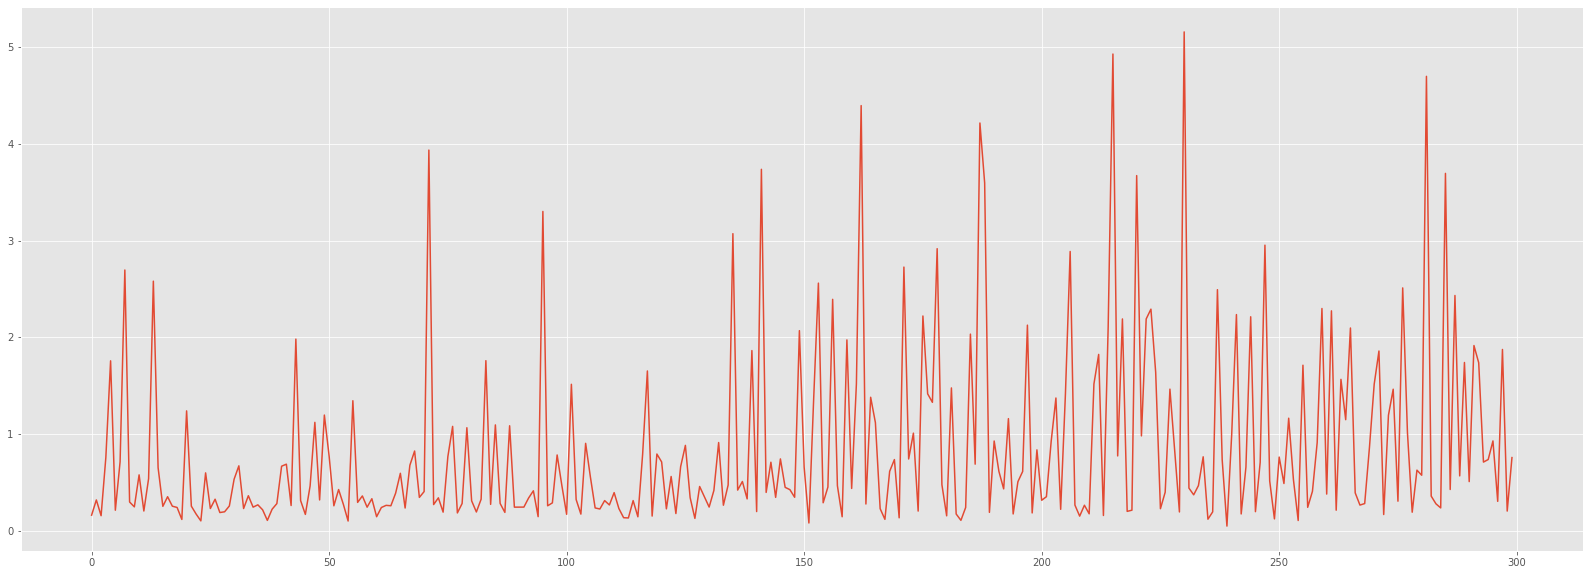

In [11]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(error_e_test)

>Si raffigurano le differenze tra il dato originale e quello ricostruito: 

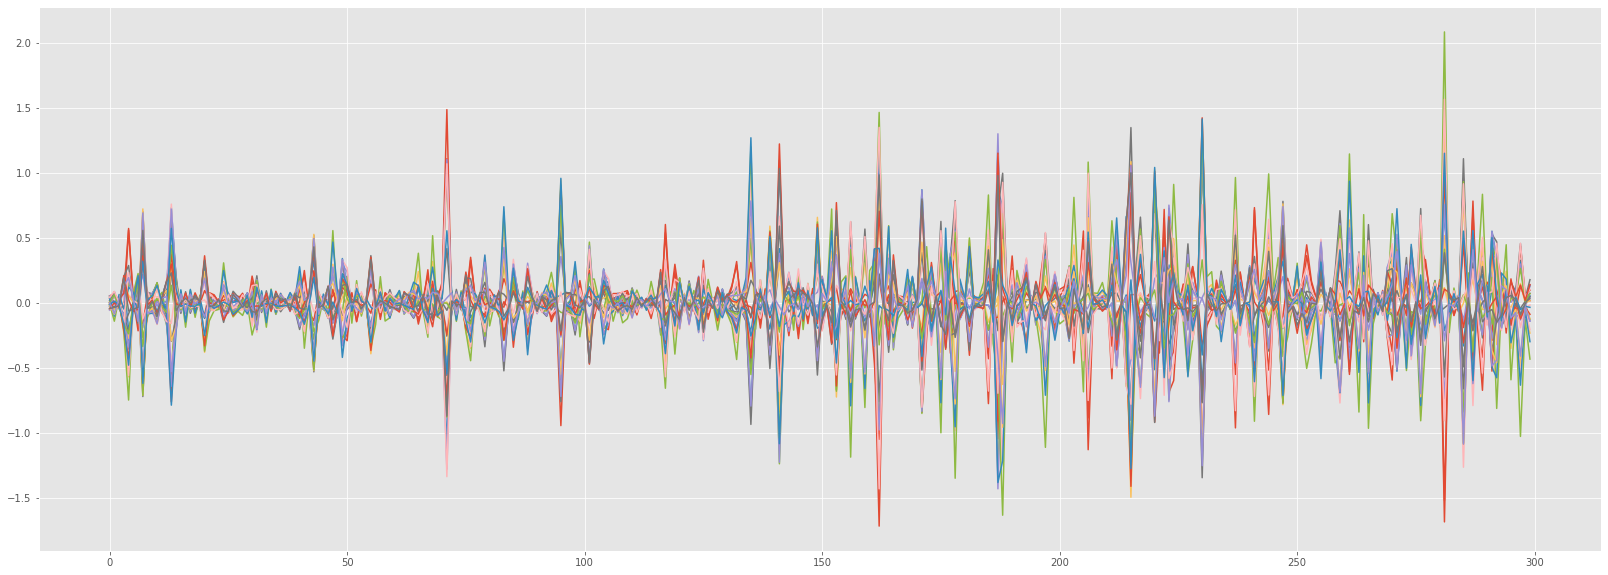

In [12]:
X=X_projected_test_kpca.T
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    for i in np.arange(0,25):
        plt.plot(np.arange(300), X_test.values.T[i,:]-X[i,:])

## Riferimenti

[1] M. Sakurada and T. Yairi, *Anomaly Detection Using Autoencoders with Nonlinear Dimensionality Reduction*, 2014 ACM